In [307]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [83]:
dataFile = 'data/covid19 _casos20200317.xlsx'

dataDF = pd.read_excel(dataFile)
dataDF.head()

,id,region,sexo,edad,centrosalud,fechainiciosintoma,fechaconfirmacion,severidad
0,1,RM,f,54,Clinica Alemana,2020-03-03,2020-03-11,leve
1,2,RM,f,40,Clinica Santa María,2020-03-11,2020-03-11,leve
2,3,RM,m,58,Clinica Alemana,2020-03-04,2020-03-11,leve
3,4,RM,m,17,Clinica Alemana,2020-03-05,2020-03-11,leve
4,5,RM,f,83,Clínica Las Condes,2020-03-04,2020-03-11,leve


In [380]:
trainDF = dataDF.groupby('fechainiciosintoma').size().cumsum()
#dataCum = pd.DataFrame(dataCum, columns=['N infectados'])
trainDF

fechainiciosintoma
2020-03-02      1
2020-03-03      3
2020-03-04      6
2020-03-05      8
2020-03-07      9
2020-03-08     11
2020-03-11     23
2020-03-12     33
2020-03-13     43
2020-03-14     61
2020-03-15     75
2020-03-16    154
2020-03-17    201
dtype: int64

In [381]:
idx = pd.date_range('2020-03-01', '2020-03-21')
trainDF = trainDF.reindex(idx, fill_value=np.NaN)
trainDF

2020-03-01      NaN
2020-03-02      1.0
2020-03-03      3.0
2020-03-04      6.0
2020-03-05      8.0
2020-03-06      NaN
2020-03-07      9.0
2020-03-08     11.0
2020-03-09      NaN
2020-03-10      NaN
2020-03-11     23.0
2020-03-12     33.0
2020-03-13     43.0
2020-03-14     61.0
2020-03-15     75.0
2020-03-16    154.0
2020-03-17    201.0
2020-03-18      NaN
2020-03-19      NaN
2020-03-20      NaN
2020-03-21      NaN
Freq: D, dtype: float64

In [382]:
trainDF['2020-03-17'] = 238
trainDF['2020-03-18'] = 342
trainDF['2020-03-19'] = 434
trainDF['2020-03-20'] = 537
trainDF['2020-03-21'] = 632
trainDF

2020-03-01      NaN
2020-03-02      1.0
2020-03-03      3.0
2020-03-04      6.0
2020-03-05      8.0
2020-03-06      NaN
2020-03-07      9.0
2020-03-08     11.0
2020-03-09      NaN
2020-03-10      NaN
2020-03-11     23.0
2020-03-12     33.0
2020-03-13     43.0
2020-03-14     61.0
2020-03-15     75.0
2020-03-16    154.0
2020-03-17    238.0
2020-03-18    342.0
2020-03-19    434.0
2020-03-20    537.0
2020-03-21    632.0
Freq: D, dtype: float64

Text(0, 0.5, 'Numero de infectados')

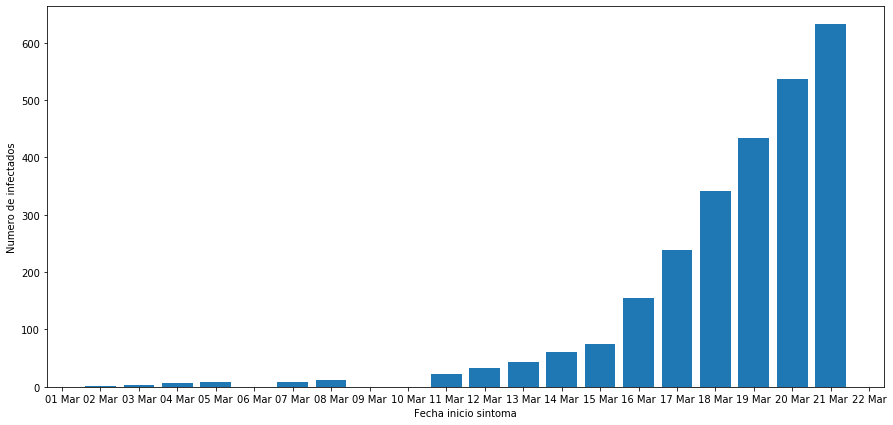

In [383]:
fig, ax = plt.subplots(figsize=(15,7))

ax.bar(trainDF.index, trainDF.values)

ax.xaxis.set_major_locator(mdates.DayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

plt.xlabel('Fecha inicio sintoma')
plt.ylabel('Numero de infectados')

Text(0, 0.5, 'Numero de infectados')

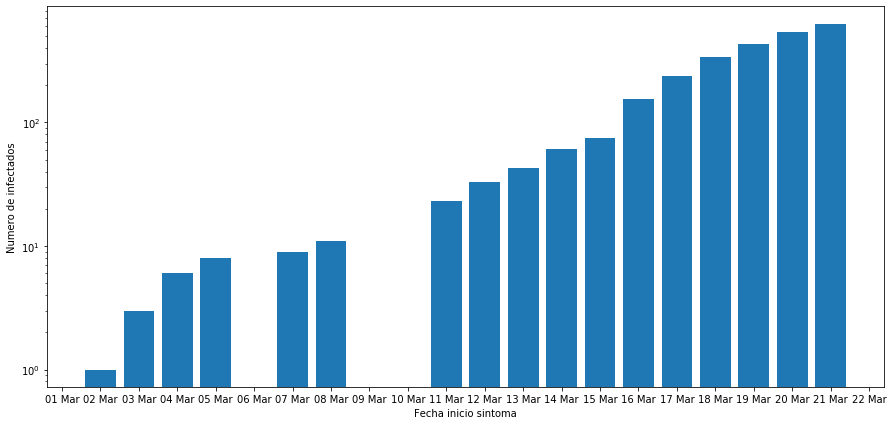

In [384]:
fig, ax = plt.subplots(figsize=(15,7))

ax.bar(trainDF.index, trainDF.values)
plt.yscale('log')

ax.xaxis.set_major_locator(mdates.DayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

plt.xlabel('Fecha inicio sintoma')
plt.ylabel('Numero de infectados')

In [431]:
param = (1,2,0)

mod = sm.tsa.statespace.SARIMAX(np.log(trainDF),
                                order=param,
                                trend='c',
                                freq='D',
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print('ARIMA{} - AIC:{}'.format(param , results.aic))

ARIMA(1, 2, 0) - AIC:7.911465206556928


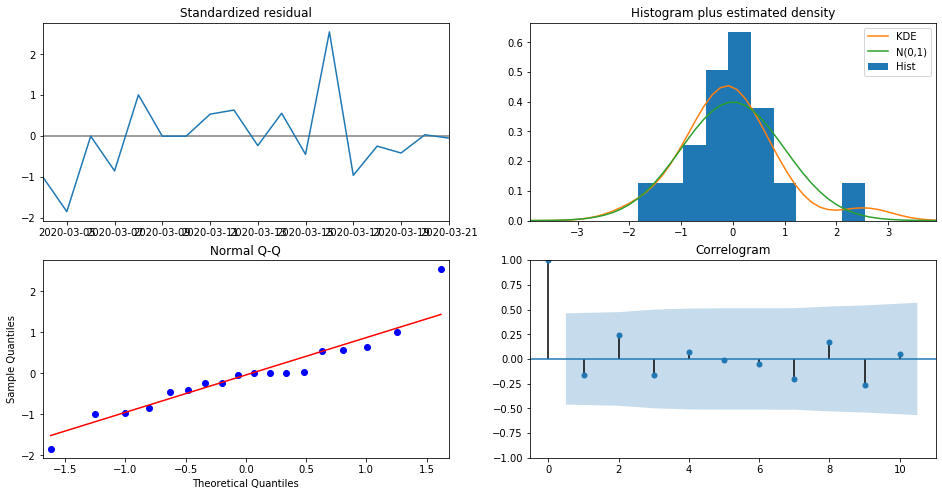

In [432]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [433]:
pred_uc = results.get_forecast(steps=13)
np.round(np.exp(pred_uc.predicted_mean))

2020-03-22    716.0
2020-03-23    780.0
2020-03-24    817.0
2020-03-25    824.0
2020-03-26    798.0
2020-03-27    744.0
2020-03-28    667.0
2020-03-29    575.0
2020-03-30    477.0
2020-03-31    380.0
2020-04-01    292.0
2020-04-02    215.0
2020-04-03    153.0
Freq: D, dtype: float64

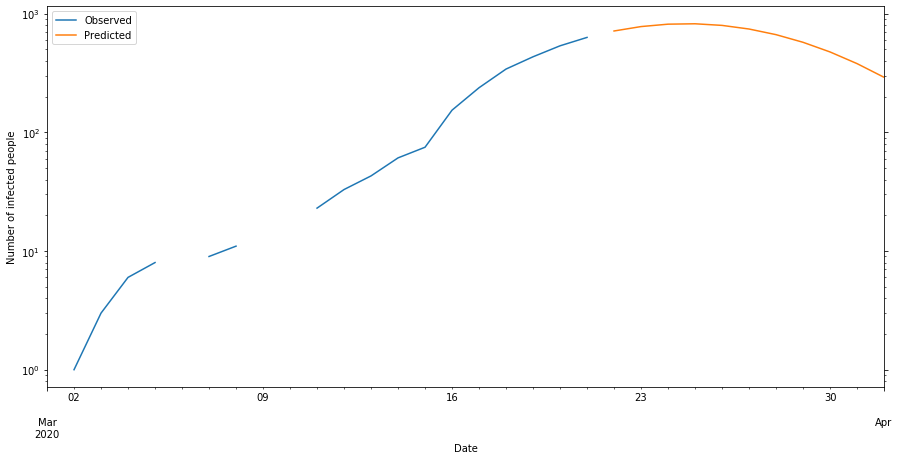

In [434]:
startDate = datetime.datetime(2020,3,1)
endDate = datetime.datetime(2020,4,1)

pred_uc = results.get_forecast(steps=14)
pred_ci = pred_uc.conf_int()

fig, ax = plt.subplots(figsize=(15, 7))
trainDF.plot(label='Observed', ax=ax)
np.exp(pred_uc.predicted_mean).plot(ax=ax, label='Predicted')

#ax.fill_between(pred_ci.index,
#                np.exp(pred_ci.iloc[:, 0]),
#                np.exp(pred_ci.iloc[:, 1]), color='k', alpha=.25)

#ax.set_xlabel('Fecha inicio sintoma')
#ax.set_ylabel('Número de infectados')
ax.set_xlabel('Date')
ax.set_ylabel('Number of infected people')

plt.yscale('log')
ax.yaxis.tick_left()
ax.yaxis.set_ticks_position('both')

plt.xlim([startDate, endDate])
plt.legend(loc='upper left')
plt.show()

fig.savefig('covid19_chile_20200318.png')

## Testing stationarity

In [180]:
from statsmodels.tsa.stattools import adfuller

def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [188]:
cleanDF = trainDF.dropna()
cleanDF

2020-03-02      1.0
2020-03-03      3.0
2020-03-04      6.0
2020-03-05      8.0
2020-03-07      9.0
2020-03-08     11.0
2020-03-11     23.0
2020-03-12     33.0
2020-03-13     43.0
2020-03-14     61.0
2020-03-15     75.0
2020-03-16    154.0
2020-03-17    201.0
dtype: float64

In [191]:
cleanDF.diff()

2020-03-02     NaN
2020-03-03     2.0
2020-03-04     3.0
2020-03-05     2.0
2020-03-07     1.0
2020-03-08     2.0
2020-03-11    12.0
2020-03-12    10.0
2020-03-13    10.0
2020-03-14    18.0
2020-03-15    14.0
2020-03-16    79.0
2020-03-17    47.0
dtype: float64

In [189]:
test_adf(cleanDF, "Numero de infectados")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Numero de infectados


In [190]:
test_adf(cleanDF.diff(), "Numero de infectados")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Numero de infectados
